# Problem Set 5

In [1]:
# imports
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import shapiro, bartlett
from matplotlib import pyplot as plt
import pandas

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf

In [3]:
def set_fontsize(ax,fsz):
    """
    Set the fontsize throughout an Axis
    
    Args:
        ax (Matplotlib Axis): 
        fsz (float): Font size

    Returns:

    """
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fsz)

----

# Question 4

## Load data

In [4]:
SIO_file = '../Data/SIO_SST.txt'
SIO_df = pandas.read_table(SIO_file, delim_whitespace=True)
SIO_df.head()

,year,SST
0,1916,15.642
1,1917,16.743
2,1918,17.385
3,1919,16.810
4,1920,16.576


## Dates

In [5]:
dates = []
for index, row in SIO_df.iterrows():
    dates.append(f'{int(row.year)}')
dates = pandas.to_datetime(dates)
SIO_df['date'] = dates
SIO_df.set_index('date', inplace=True)
# Remove Year
SIO_df.drop(columns='year', inplace=True)
SIO_df.head()

,SST
date,
1916-01-01,15.642
1917-01-01,16.743
1918-01-01,17.385
1919-01-01,16.810
1920-01-01,16.576


## Prep for fitting

In [6]:
data = pandas.DataFrame()
data['SST'] = SIO_df.SST.values
data.index = SIO_df.index

In [7]:
dummy0 = np.zeros(len(data))
dummy0[data.index >= pandas.to_datetime('1989')] = 1
data['dummy0'] = dummy0
data.dummy0[-40:-30]

date
1981-01-01    0.0
1982-01-01    0.0
1983-01-01    0.0
1984-01-01    0.0
1985-01-01    0.0
1986-01-01    0.0
1987-01-01    0.0
1988-01-01    0.0
1989-01-01    1.0
1990-01-01    1.0
Name: dummy0, dtype: float64

## Fit

In [8]:
dummy0_formula = "SST ~ dummy0"
mod_dummy0 = smf.glm(formula=dummy0_formula, data=data).fit()#, family=sm.f
mod_dummy0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    SST   No. Observations:                  105
Model:                            GLM   Df Residuals:                      103
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.41249
Method:                          IRLS   Log-Likelihood:                -101.49
Date:                Mon, 09 May 2022   Deviance:                       42.487
Time:                        09:33:59   Pearson chi2:                     42.5
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4625
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.9302      0.075    225.224      0.000      16.783      17.078
dummy0         1.0992      0.136      8.073      0.000       0.832       1.366
==============================================================================
"""

In [9]:
mod_dummy0.pvalues

Intercept    0.000000e+00
dummy0       6.874123e-16
dtype: float64

## The intervention has magnitude of 1.1 (with error of 0.14)

## We recover a p-value of 6.874123e-16 for the intervention

## Plot

In [19]:
data['ols'] = mod_dummy0.fittedvalues

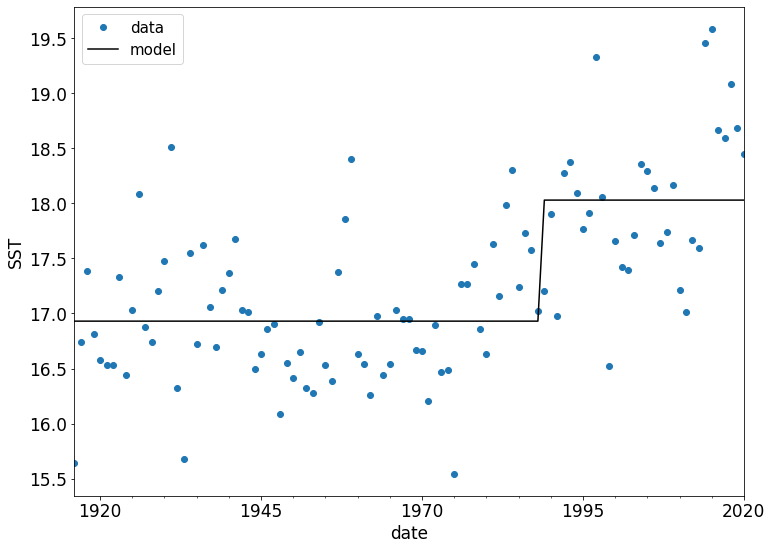

In [20]:
fig = plt.figure()
fig.set_size_inches((12, 9))
ax = data.SST.plot(ylabel='SST', label='data', marker='o', ls='')
#
data.ols.plot(ax=ax, color='k', label='model')
#
ax.legend(fontsize=15)
#
set_fontsize(ax, 17)

----

# Question 5 -- AIC

In [10]:
mod_dummy0.aic

206.97684413808415

## The AIC is 206.98

----

# Question 6 -- Fit with GLS

## Prep anew

In [21]:
gls_data = pandas.DataFrame()
# endogd
gls_data['d'] = data.SST.values
# endoge
gls_endog = pandas.DataFrame()
gls_endog['dum'] = data.dummy0.values
gls_endog['intercept'] = 1.

## Fit

In [22]:
glsar_model = sm.GLSAR(gls_data.d, gls_endog, 1)
glsar_results = glsar_model.iterative_fit(15)
print(glsar_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:                      d   R-squared:                       0.235
Model:                          GLSAR   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     31.29
Date:                Mon, 09 May 2022   Prob (F-statistic):           1.87e-07
Time:                        09:47:18   Log-Likelihood:                -92.319
No. Observations:                 104   AIC:                             188.6
Df Residuals:                     102   BIC:                             193.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dum            1.0479      0.187      5.594      0.0

## Plot

In [25]:
glsar_results.fittedvalues

0      16.967104
1      16.967104
2      16.967104
3      16.967104
4      16.967104
         ...    
100    18.015022
101    18.015022
102    18.015022
103    18.015022
104    18.015022
Length: 105, dtype: float64

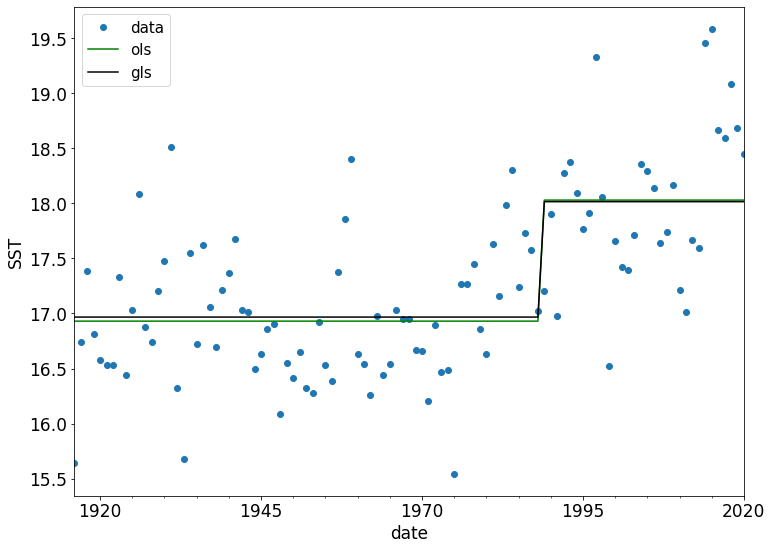

In [28]:
fig = plt.figure()
fig.set_size_inches((12, 9))
ax = data.SST.plot(ylabel='SST', label='data', marker='o', ls='')
#
data.ols.plot(ax=ax, color='g', label='ols')
data.gls1.plot(ax=ax, color='k', label='gls')
#
ax.legend(fontsize=15)
#
set_fontsize(ax, 17)
#plt.savefig('PS4_Q1.png', dpi=300)

In [30]:
glsar_results.params

dum           1.047918
intercept    16.967104
dtype: float64

In [31]:
glsar_results.pvalues

dum           1.872428e-07
intercept    2.595200e-124
dtype: float64

## The intervention has value 1.05 (very nearly the same)

## The p-value is 1.87e-7. still highly significant

----

# Question 7 -- AIC of GLS

In [32]:
glsar_results.aic

188.63844491386385

## We recover an AIC = 188.6 for the GLS model

## This is smaller than the OLS model and enough so that it is much preferred

----

# Question 8 -- Fit without intervention

## Prep

In [36]:
# endoge
gls_endog2 = pandas.DataFrame()
gls_endog2['intercept'] = np.ones(len(gls_data.d))

## Fit

In [37]:
glsar_model2 = sm.GLSAR(gls_data.d, gls_endog2, 1)
glsar_results2 = glsar_model2.iterative_fit(15)
print(glsar_results2.summary())

                           GLSAR Regression Results                           
Dep. Variable:                      d   R-squared:                       0.000
Model:                          GLSAR   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 09 May 2022   Prob (F-statistic):                nan
Time:                        10:00:12   Log-Likelihood:                -101.10
No. Observations:                 104   AIC:                             204.2
Df Residuals:                     103   BIC:                             206.8
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     17.3195      0.154    112.808      0.0

In [38]:
glsar_results2.aic

204.19389413082388

## AIC = 204.19 for this model without an intervention

## This model is clearly not favored over the AR(1) model with an intervention